In [129]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import QuantileTransformer
import statsmodels.api as sm
from sklearn.decomposition import PCA

df = pd.read_excel('./dataset_9/cars_9.xlsx')

*<h2>Function for performing PCA and plotting graphs</h2>*

In [130]:

def pca_results(data, pca):
    
    # Dimension indexing
    dimensions = ['PC {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()) 
    components.index = dimensions

    #PCA eigenvalues
    ev = pca.explained_variance_.reshape(len(pca.components_), 1)
    eigenvalues = pd.DataFrame(np.round(ev, 4), columns = ['Eigenvalue']) 
    eigenvalues.index = dimensions
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    # Compute the cumulative % variance explained
    cum_variance_ratios = np.cumsum(variance_ratios)
    cum_variance_ratios.columns = ['Cumulative Variance Explained']

    # Return a concatenated DataFrame
    return pd.concat([eigenvalues, variance_ratios, cum_variance_ratios , components], axis = 1)

In [131]:
def scoreplot_label(data, scores, pca, width=5, height=5, margin=0.5):
    plt.figure(figsize=(width, height))
    ax = sns.scatterplot(x="PC1", y="PC2", data = scores, hue = data['Brand'])
    
    # Print text
    # text_pos = 0.2
    
    # for i, v in enumerate(np.array(scores)):
    #     # ax.arrow(0, 0, v[0], v[1], head_width=0.1, head_length=0.1, linewidth=2, color='red')
    #     ax.text(v[0], v[1]+text_pos, data.iloc[i,0], color='black', ha='center', va='center', fontsize=5)
    
    
    #Set limits for figure
    x_min = min(scores['PC1'].min(),0)-margin
    x_max = max(scores['PC1'].max(),0)+margin
    y_min = min(scores['PC2'].min(),0)-margin
    y_max = max(scores['PC2'].max(),0)+margin
  
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title("Score plot", fontsize=14)
    plt.plot([x_min, x_max], [0, 0], color='k', linestyle='--', linewidth=1)
    plt.plot([0, 0], [y_min, y_max], color='k', linestyle='--', linewidth=1)
    return ax

In [132]:
def loadingplot(data, pca, width=5, height=5, margin=0.5):

    fig, ax = plt.subplots(figsize = (width,height))

    #Set limits for figure
    x_min = min(pca.components_[0,:].min(),0)-margin
    x_max = max(pca.components_[0,:].max(),0)+margin
    y_min = min(pca.components_[1,:].min(),0)-margin
    y_max = max(pca.components_[1,:].max(),0)+margin

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    #Scaling factor for text position
    text_pos = 0.2

    for i, v in enumerate(pca.components_.T):
        ax.arrow(0, 0, v[0], v[1], head_width=0.1, head_length=0.1, linewidth=2, color='red')
        ax.text(v[0], v[1]+text_pos, data.columns[i], color='black', ha='center', va='center', fontsize=12)

    plt.plot([x_min, x_max], [0, 0], color='k', linestyle='--', linewidth=1)
    plt.plot([0, 0], [y_min, y_max], color='k', linestyle='--', linewidth=1)
    ax.set_xlabel("PC1", fontsize=14)
    ax.set_ylabel("PC2", fontsize=14)
    ax.set_title("Loading plot", fontsize = 14)
    
    return ax

---


In [133]:
df

,Brand,Type,Wheel-base,Length,Width,Height,Curb-weight,Cylinders,Engine,Compression-ratio,Horsepower,City-mpg,Highway-mpg,Price
0,alfa-romero,convertible,88.6,168.8,64.1,48.8,2548,4,130,9.0,111,21,27,13495
1,alfa-romero,convertible,88.6,168.8,64.1,48.8,2548,4,130,9.0,111,21,27,16500
2,alfa-romero,hatchback,94.5,171.2,65.5,52.4,2823,6,152,9.0,154,19,26,16500
3,audi,sedan,99.4,176.6,66.4,54.3,2824,5,136,8.0,115,18,22,17450
4,audi,sedan,99.8,177.3,66.3,53.1,2507,5,136,8.5,110,19,25,15250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,volvo,sedan,109.1,188.8,68.9,55.5,2952,4,141,9.5,114,23,28,16845
191,volvo,sedan,109.1,188.8,68.8,55.5,3049,4,141,8.7,160,19,25,19045
192,volvo,sedan,109.1,188.8,68.9,55.5,3062,4,141,9.5,114,19,25,22625
193,volvo,sedan,109.1,188.8,68.9,55.5,3012,6,173,8.8,134,18,23,21485


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              195 non-null    object 
 1   Type               195 non-null    object 
 2   Wheel-base         195 non-null    float64
 3   Length             195 non-null    float64
 4   Width              195 non-null    float64
 5   Height             195 non-null    float64
 6   Curb-weight        195 non-null    int64  
 7   Cylinders          195 non-null    int64  
 8   Engine             195 non-null    int64  
 9   Compression-ratio  195 non-null    float64
 10  Horsepower         195 non-null    int64  
 11  City-mpg           195 non-null    int64  
 12  Highway-mpg        195 non-null    int64  
 13  Price              195 non-null    int64  
dtypes: float64(5), int64(7), object(2)
memory usage: 21.5+ KB


---

***<h3>Univariate Analysis</h3>***

***<h5>the assumptions and limitations of PCA are as follows:</h5>***

- The variables should be linearly related and have a linear correlation

- the principal components are orthogonal 

- If variables are normally distributed, then PCA will work better

- correlation coefficient tends to be less reliable when estimated from small samples therefore, it is important that sample size be large enough that correlations are reliably estimated.

In [135]:
column = 'Wheel-base'

fig = px.histogram(df, x= column, nbins=30)

fig.update_layout(
    title="Distribution of " + column,
    xaxis_title=column,
    yaxis_title="Count"
)

In [136]:
column = 'Horsepower'

fig = px.histogram(df, x= column, nbins=30)

fig.update_layout(
    title="Distribution of " + column,
    xaxis_title=column,
    yaxis_title="Count"
)

In [137]:
column = 'Price'

fig = px.histogram(df, x= column, nbins=30)

fig.update_layout(
    title="Distribution of " + column,
    xaxis_title=column,
    yaxis_title="Count"
)

In [138]:
# columns_to_transform = ['Wheel-base', 'Length', 'Width', 'Height', 'Curb-weight', 'Cylinders', 'Cylinders', 'Cylinders','Horsepower','City-mpg','Highway-mpg','Price']

# pca = PCA()
# principal_components = pca.fit_transform(df[columns_to_transform])

# # Calculate correlation matrix
# correlation_matrix = np.corrcoef(principal_components.T)

# # Check for orthogonality
# is_orthogonal = np.allclose(correlation_matrix, np.eye(correlation_matrix.shape[0]))
# print("Are the principal components orthogonal?", is_orthogonal)

---

**<h1>`Question 2 (A)`</h1>**

In [139]:
df

,Brand,Type,Wheel-base,Length,Width,Height,Curb-weight,Cylinders,Engine,Compression-ratio,Horsepower,City-mpg,Highway-mpg,Price
0,alfa-romero,convertible,88.6,168.8,64.1,48.8,2548,4,130,9.0,111,21,27,13495
1,alfa-romero,convertible,88.6,168.8,64.1,48.8,2548,4,130,9.0,111,21,27,16500
2,alfa-romero,hatchback,94.5,171.2,65.5,52.4,2823,6,152,9.0,154,19,26,16500
3,audi,sedan,99.4,176.6,66.4,54.3,2824,5,136,8.0,115,18,22,17450
4,audi,sedan,99.8,177.3,66.3,53.1,2507,5,136,8.5,110,19,25,15250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,volvo,sedan,109.1,188.8,68.9,55.5,2952,4,141,9.5,114,23,28,16845
191,volvo,sedan,109.1,188.8,68.8,55.5,3049,4,141,8.7,160,19,25,19045
192,volvo,sedan,109.1,188.8,68.9,55.5,3062,4,141,9.5,114,19,25,22625
193,volvo,sedan,109.1,188.8,68.9,55.5,3012,6,173,8.8,134,18,23,21485


In [140]:
df = pd.read_excel('./dataset_9/cars_9.xlsx')
df1 = df.drop(['Brand', 'Type'], axis=1)
df.head()

,Brand,Type,Wheel-base,Length,Width,Height,Curb-weight,Cylinders,Engine,Compression-ratio,Horsepower,City-mpg,Highway-mpg,Price
0,alfa-romero,convertible,88.6,168.8,64.1,48.8,2548,4,130,9.0,111,21,27,13495
1,alfa-romero,convertible,88.6,168.8,64.1,48.8,2548,4,130,9.0,111,21,27,16500
2,alfa-romero,hatchback,94.5,171.2,65.5,52.4,2823,6,152,9.0,154,19,26,16500
3,audi,sedan,99.4,176.6,66.4,54.3,2824,5,136,8.0,115,18,22,17450
4,audi,sedan,99.8,177.3,66.3,53.1,2507,5,136,8.5,110,19,25,15250


>Check if the components are orthogonal

In [141]:
pca = PCA()
principal_components = pca.fit_transform(df1)

# Calculate correlation matrix
correlation_matrix = np.corrcoef(principal_components.T)

# Check for orthogonality
is_orthogonal = np.allclose(correlation_matrix, np.eye(correlation_matrix.shape[0]))
print("Are the principal components orthogonal?", is_orthogonal)


Are the principal components orthogonal? True


In [142]:
data_standardized = (df1 - df1.mean())/df1.std()
data_standardized.head()

,Wheel-base,Length,Width,Height,Curb-weight,Cylinders,Engine,Compression-ratio,Horsepower,City-mpg,Highway-mpg,Price
0,-1.651399,-0.434250,-0.833568,-2.117092,-0.014783,-0.392257,0.056339,-0.299118,0.212479,-0.692920,-0.570092,0.024923
1,-1.651399,-0.434250,-0.833568,-2.117092,-0.014783,-0.392257,0.056339,-0.299118,0.212479,-0.692920,-0.570092,0.393069
2,-0.696418,-0.240883,-0.172813,-0.615426,0.515125,1.594500,0.588700,-0.299118,1.347280,-1.006422,-0.717529,0.393069
3,0.096702,0.194194,0.251958,0.177120,0.517052,0.601121,0.201528,-0.538835,0.318042,-1.163173,-1.307280,0.509455
4,0.161446,0.250593,0.204762,-0.323436,-0.093788,0.601121,0.201528,-0.418976,0.186088,-1.006422,-0.864967,0.239930


> Standardize the data

In [143]:
# implementing PCA using sklearn

from sklearn.decomposition import PCA

pca = PCA(n_components=12).fit(data_standardized)
#Note that pca.transform() returns scores based on centred data
pca_samples = pca.transform(data_standardized)

In [144]:
pca_results = pca_results(data_standardized, pca)
pca_results

,Eigenvalue,Explained Variance,Cumulative Variance Explained,Wheel-base,Length,Width,Height,Curb-weight,Cylinders,Engine,Compression-ratio,Horsepower,City-mpg,Highway-mpg,Price
PC 1,7.4025,0.6169,0.6169,0.2750,0.3203,0.3211,0.1069,0.3512,0.2651,0.3315,0.0044,0.3065,-0.3127,-0.3222,0.3287
PC 2,2.0636,0.1720,0.7889,-0.3882,-0.2562,-0.1903,-0.5242,-0.0935,0.2260,0.1345,-0.4762,0.3046,-0.2087,-0.1577,0.0821
PC 3,1.0965,0.0914,0.8803,-0.1284,-0.1378,0.0434,-0.3313,0.0387,0.3976,0.2672,0.6076,0.0419,0.3222,0.3045,0.2334
PC 4,0.4388,0.0366,0.9169,-0.0241,-0.1259,-0.2435,0.6322,-0.1529,0.5416,0.1508,-0.3181,-0.0284,0.1920,0.1710,0.1305
PC 5,0.3332,0.0278,0.9447,-0.4290,-0.1276,-0.3894,0.3695,0.0658,-0.1898,-0.1122,0.4562,0.3134,-0.2802,-0.2211,0.1577
PC 6,0.1898,0.0158,0.9605,-0.0212,0.0090,-0.0853,-0.0476,0.0288,0.5153,-0.0618,0.2380,-0.3471,-0.2548,-0.3839,-0.5747
PC 7,0.1369,0.0114,0.9719,-0.2707,-0.2949,0.7181,0.1405,-0.2915,0.1343,-0.3693,0.0292,-0.0599,-0.0970,-0.1101,0.1975
PC 8,0.1112,0.0093,0.9812,-0.3058,0.3496,0.2461,0.1089,0.0331,0.0802,-0.0340,-0.0241,0.5576,0.1367,0.2774,-0.5442
PC 9,0.0858,0.0071,0.9883,-0.1724,0.7112,-0.1795,-0.1427,-0.3011,0.1824,-0.3364,0.0089,-0.1692,-0.1499,0.1280,0.3274
PC 10,0.0720,0.0060,0.9943,-0.6025,0.1504,0.1535,0.0928,0.4233,-0.1499,0.3350,-0.1471,-0.4923,0.0228,0.0487,0.0386


> This time i will use the cumulative covariance to determine the number of components to use  
>as we can see PC3 is enough to capture 80% of the variance so we will only keep those 3 

<Figure size 640x480 with 0 Axes>

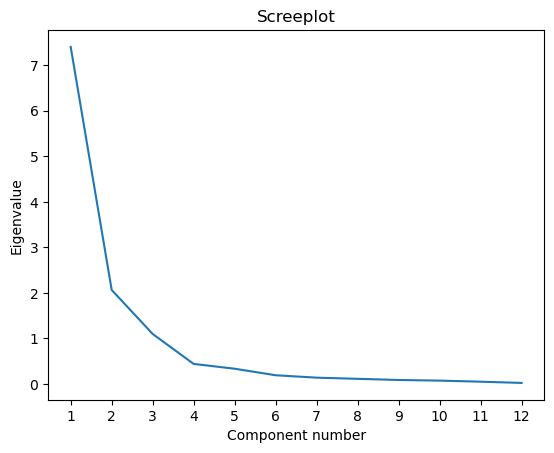

In [145]:
#Scree plot
import matplotlib.ticker as ticker
plt.clf()
fig1, ax1 = plt.subplots()
ax1.plot(np.arange(1, len(pca.explained_variance_)+1), pca.explained_variance_)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set(xlabel = 'Component number', ylabel = 'Eigenvalue', title = 'Screeplot')
plt.show()

> Although scree plot say to keep 4 PCs 3 PCs are enough to capture 80% of the variance as we infer from above so we will keep 3 PCs and discard the rest

In [150]:
#Extract only the three PCs
pca2 = PCA(n_components=3).fit(data_standardized)
scores2 = pca2.transform(data_standardized)

> Extract 3 PCs

In [151]:
#Obtain scores from original data that are not centred

scores_notcentred2 = np.dot(data_standardized, pca2.components_.T)
scores_notcentred2 = pd.DataFrame(scores_notcentred2, columns = ['PC1', 'PC2', 'PC3'])
scores_notcentred2.head()

,PC1,PC2,PC3
0,-0.705354,2.384813,0.231644
1,-0.584352,2.415041,0.317554
2,1.495695,1.987229,0.553729
3,1.643993,0.730725,-0.742141
4,1.076594,0.797768,-0.428481


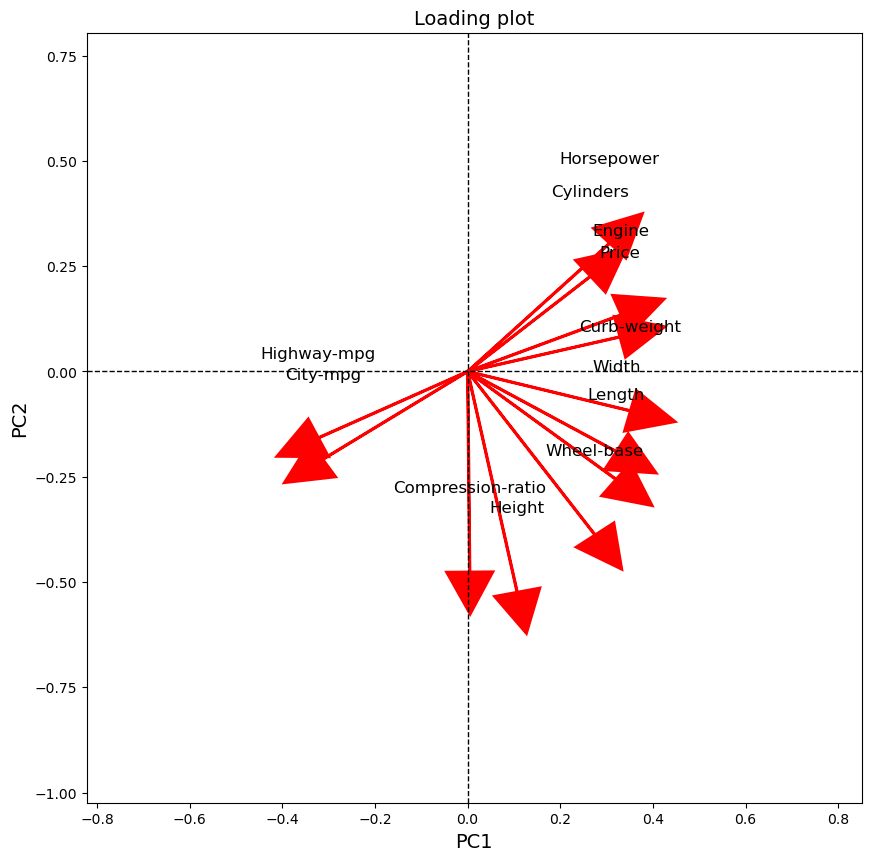

In [148]:
plt.clf
ax2 = loadingplot(data_standardized, pca, width=10, height=10)
plt.show()

> A quick analysis on the loading plot

- PC1 Highway MPG, city MPG contributes negatively to the PC while the rest contributed positively

- PC2 Only price, engine, cylinder horsepower contributed positively to PC2 while the rest constributed negatively

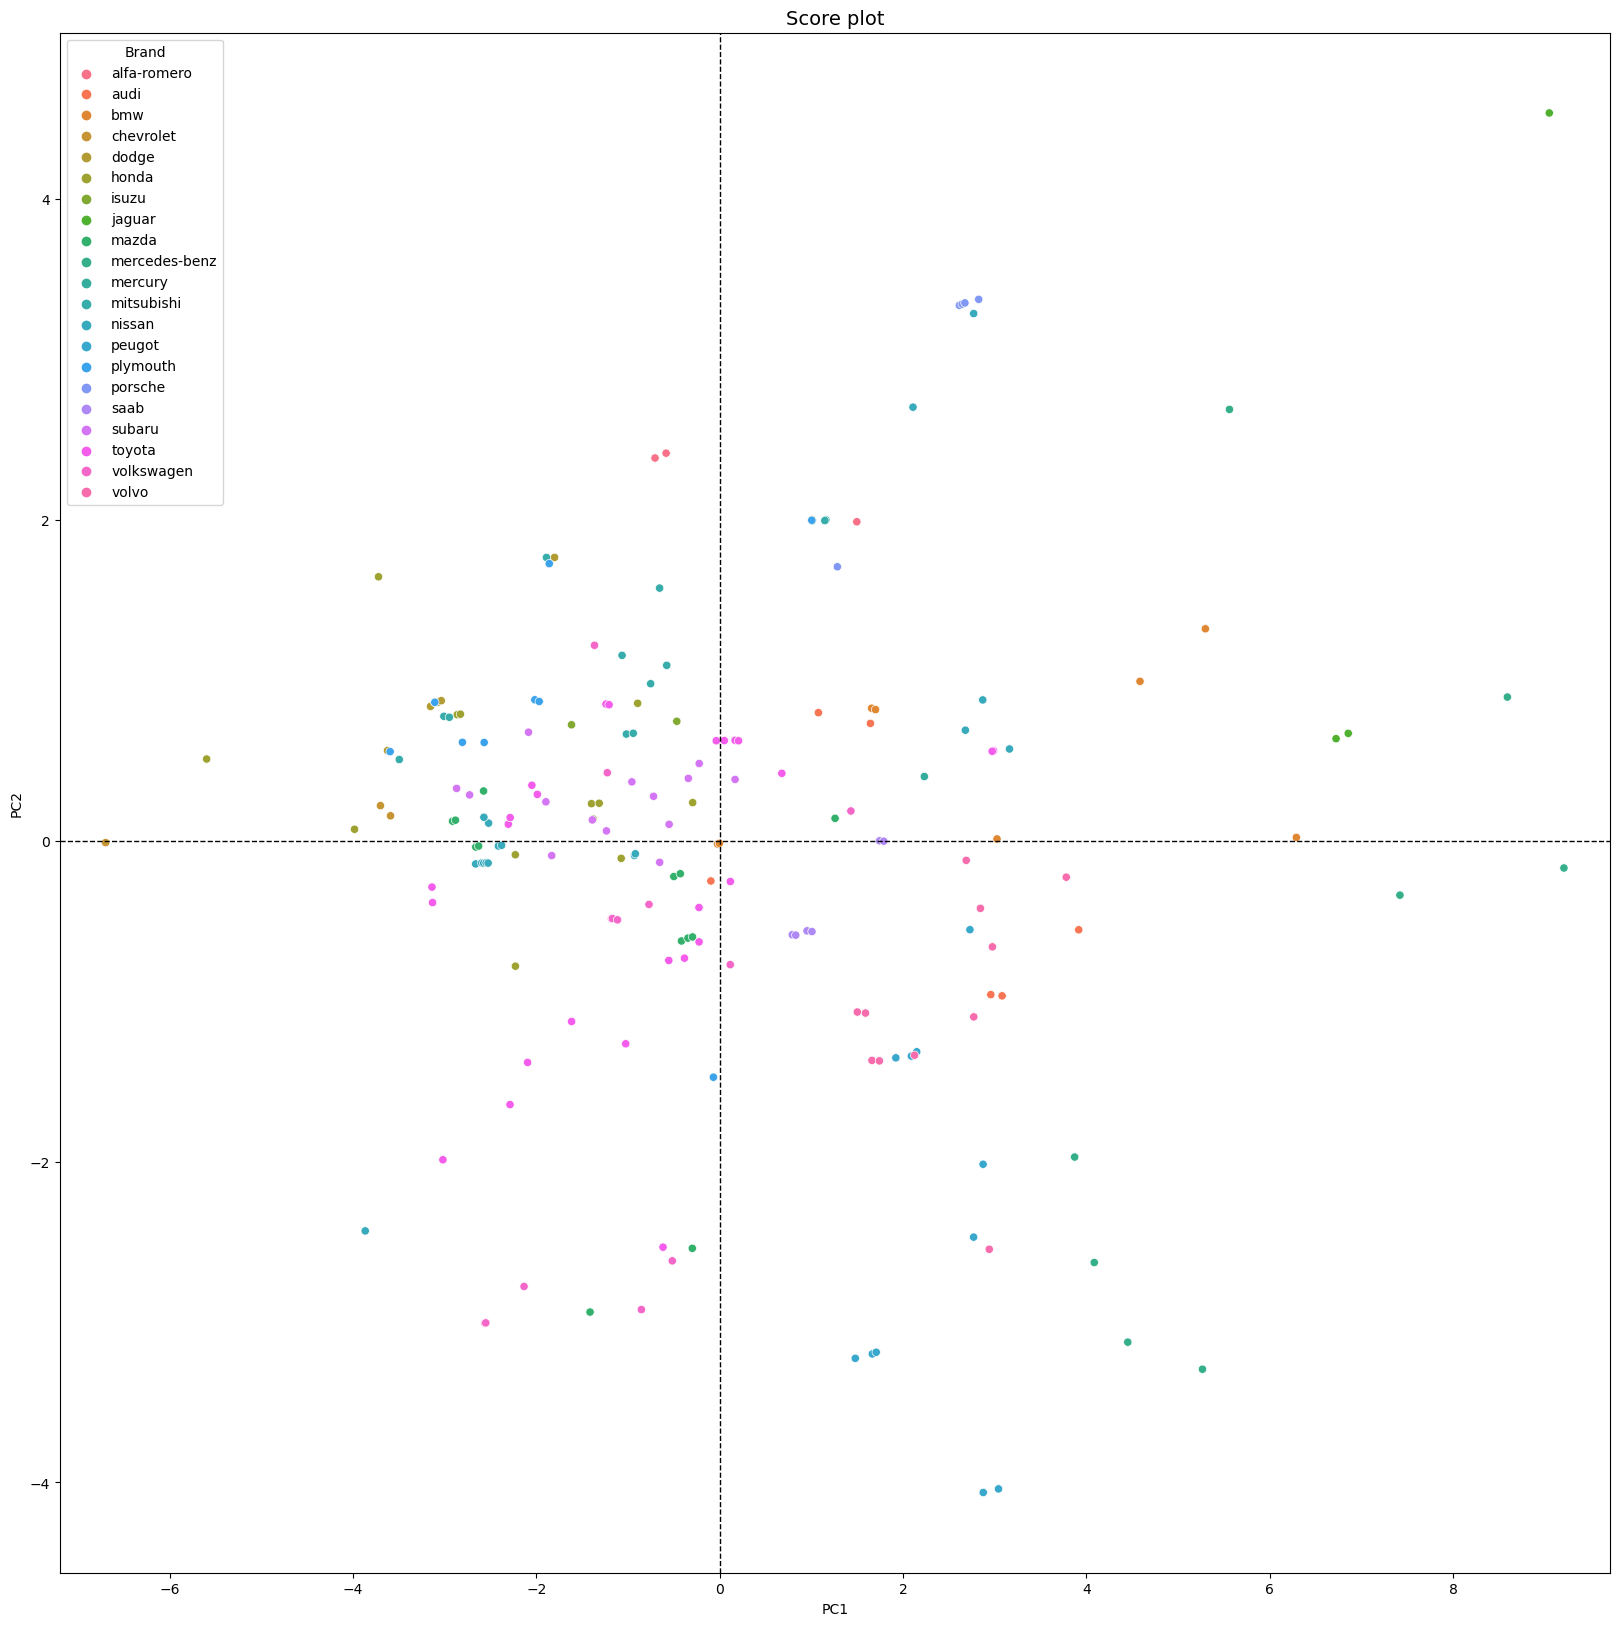

In [149]:
plt.clf

ax3 = scoreplot_label(df, scores_notcentred2, pca2, width=20, height=20)
plt.show()


---

**<h2>Question 2 (B)</h2>**

*<h3>`Usefullness of PCA for clustering/classification`</h3>*

For this question i feel like PCA is not useful in terms of classification/clustering due to these few points:

- Although PCA managed to successfully reduce the number of dimensions from 12 to 3 

- The data on the score plot does not appear in clusters making it hard to infer upon

- This difficulity would definitely be not desirable for classification/clustering projects hence not useful

---

Lasagna Recipe (click to read all)

<!-- ## Ingredients:
- 1 pound (450g) ground beef
- 1 onion, finely chopped
- 3 cloves garlic, minced
- 1 can (14 ounces/400g) crushed tomatoes
- 1 can (6 ounces/170g) tomato paste
- 1/2 cup water
- 2 teaspoons dried basil
- 2 teaspoons dried oregano
- Salt and pepper to taste
- 9 lasagna noodles, cooked and drained
- 2 cups shredded mozzarella cheese
- 1 cup grated Parmesan cheese
- Fresh parsley, for garnish

## Instructions:
1. Preheat the oven to 375°F (190°C).

2. In a large skillet, cook the ground beef, onion, and garlic over medium heat until the beef is browned and the onion is tender. Drain any excess fat.

3. Add crushed tomatoes, tomato paste, water, dried basil, dried oregano, salt, and pepper to the skillet. Stir well to combine. Simmer the sauce for about 15 minutes to allow the flavors to develop.

4. In a greased 9x13-inch baking dish, spread a thin layer of the meat sauce. Place three lasagna noodles on top of the sauce. Spread a layer of meat sauce over the noodles, followed by a layer of mozzarella cheese and Parmesan cheese. Repeat the layers, ending with a layer of cheese on top.

5. Cover the baking dish with aluminum foil and bake in the preheated oven for 25 minutes. Then, remove the foil and bake for an additional 10 minutes or until the cheese is bubbly and golden.

6. Remove the lasagna from the oven and let it cool for a few minutes. Garnish with fresh parsley.

7. Slice and serve the lasagna while it's still hot and delicious!

Enjoy your homemade lasagna! -->